In [155]:
import torch
import torch.nn as nn
import numpy as np
import scipy.stats
import scipy.integrate
from typing import List

import matplotlib.pyplot as plt

#### dataset

In [156]:
def gen_data(batch_size = 128,
             x0s = [-.5,1,2],
             sigmas = [.25,.25,.5],
             ps = [0.4,0.3,0.3],
             scale = 1.0):
    '''
    mixture of gaussian data generator: 3 gaussian sources in 1d
    '''
    assert len(x0s) == len(sigmas) & len(ps) == len(sigmas), 'incompatible dims'
    
    ixs = np.random.choice([0,1,2],size=(batch_size,))
    x0 = torch.as_tensor(list(map(lambda x: x0s[x], ixs)))
    sigma = torch.as_tensor(list(map(lambda x: sigmas[x], ixs)))
    
    data = (x0 + sigma*torch.randn_like(sigma))*scale
    data = data.view(-1,1)
    return data

#### parameters

In [157]:
beta_min = 0.1
beta_max = 20 
T = 1
Teps = 1e-5
dt = 1e-2      

#### forward process

In [158]:
def forward_x(x0,t):
    A = torch.exp(-1/2*(beta_min*t + 1/(2*T)*(beta_max-beta_min)*t**2))
    B = torch.sqrt(1-A**2)
    noise = torch.randn_like(x0)
    return A*x0 + B*noise, noise

#### backward process

In [160]:
def sample_sde(score_net, batch_size = 128, store_intermediate = True, dt = 5e-3):
    '''
    sampler via Langevin equation (SDE)
    '''
    score_net.eval()

    def reverse_step(xt,t):
        beta0 = beta(t)
        tmat = (torch.ones_like(xt)*t)[:,-1:]
        output = score_net(xt,tmat).detach()
        xt_new = xt + (1/2*beta0*xt+ beta0*output)*dt 
        xt_new += np.sqrt(beta0)*torch.randn_like(xt)*np.sqrt(dt)
        return xt_new

    xT = torch.randn(batch_size,1).to(device)

    N = int(T/dt)
    steps = list(range(N,0,-1))
    t = np.array([s*dt for s in steps]+[Teps])

    if store_intermediate:
        xts = xT.unsqueeze(-2)
        for n in steps:
            xt = reverse_step(xts[...,-1:,:],n*dt)
            xts = torch.cat((xts,xt),axis=-2)
#             return xts.float().cpu()
        return t, np.transpose(xts.cpu().numpy(),[0,2,1])

    else:
        xt = xT
        for n in steps:
            xt = reverse_step(xt,n*dt)
        return t, xt.cpu().numpy()

#### forward process (Langevin sampling, Prob. flow sampling + Prob. flow likelihood)

In [161]:
def sample_ode(score_net, batch_size = 128, store_intermediate = True):
    '''
    samples via probability flow equation (ODE)
    '''
    def gen_sample(init_x: np.ndarray, rtol=1e-5, atol=1e-5, method='RK45'):

        def ode_func(x, t):
            return -0.5 * beta(t) * ( x + score_net(x, t))

        def x_ode_solver_func(t: float, x: np.ndarray):

            x = torch.from_numpy(x.reshape(x_npts,x_dim))
            x = x.to(device).float()
            t = (torch.ones(x_npts, 1).to(device) * t).requires_grad_(False)

            drift = ode_func(x, t).reshape(-1).detach().cpu().numpy()

            return drift

        x_npts,x_dim = init_x.shape
        init_x = init_x.reshape(-1)
        N = int(T/dt)+1
        solution = scipy.integrate.solve_ivp(x_ode_solver_func, 
                                             (T,Teps), 
                                             init_x, rtol=rtol, 
                                             atol=atol, 
                                             method=method, 
                                             t_eval = np.linspace(T,Teps,N))

        t = solution.t
        if store_intermediate:
            sol = solution.y
            final_xs = sol.reshape(x_npts,x_dim,N)
            return t, final_xs
        else:
            sol = solution.y[:, -1]
            final_x = sol.reshape(x_npts,x_dim)
            return t, final_x

    init_x = np.random.randn(batch_size,1)
    t, final_x = gen_sample(init_x = init_x)

    return t, final_x

In [162]:
def likelihood_ode(score_net, x_low = -4., x_high = 4., x_npts = 10000):
    '''
    likelihood via probability flow equation (ODE)
    '''
    def gen_score_net_div(score_net):
        def score_net_div(x,t):
            x.requires_grad_(True)
            model_output = score_net(x, t)
            model_div = torch.autograd.grad(torch.sum(model_output), x, create_graph=True)[0]
            x.requires_grad_(False)
            return model_div

        return score_net_div
    
    def gen_ode_likelihood(init_x: np.ndarray, rtol=1e-5, atol=1e-5, method='RK45'):

        def ode_func(x, t):
            return -0.5 * beta(t) * ( x + score_net(x, t))

        def ode_func_div(x, t):
            return -0.5 * beta(t) * ( 1 + score_net_div(x, t))

        def prior_logp(z):
            logZ = -0.5 * np.log(2 * np.pi)
            return (logZ - 0.5 * z**2).sum(axis=1, keepdims=True)

        def x_logp_ode_solver_func(t: float, x_logp: np.ndarray):

            x = torch.from_numpy(x_logp[:x_npts*x_dim].reshape(x_npts,x_dim))
            x = x.to(device).float()
            t = (torch.ones(x_npts, 1).to(device) * t).requires_grad_(False)

            drift = ode_func(x, t).reshape(-1).detach().cpu().numpy()
            logp_grad = ode_func_div(x, t).reshape(-1).detach().cpu().numpy()

            return np.concatenate([drift,logp_grad],axis=0)

        x_npts,x_dim = init_x.shape
        init_x_logp = np.concatenate([init_x.reshape(-1),np.zeros(x_npts)],axis=0)
        solution = scipy.integrate.solve_ivp(x_logp_ode_solver_func, 
                                             (Teps,T), 
                                             init_x_logp, 
                                             rtol=rtol, 
                                             atol=atol, 
                                             method=method, 
                                             t_eval = np.linspace(Teps,T,100))

        t = solution.t
        sol = solution.y[:, -1]
        x = sol[:x_npts*x_dim].reshape(x_npts,x_dim)
        logp = sol[x_npts*x_dim:].reshape(x_npts,1)

        logpT = prior_logp(x) # log(p(x(T)))
        logp = logpT + logp

        return logp
    
    score_net_div = gen_score_net_div(score_net)
    
    init_x = np.linspace(x_low,x_high,x_npts)
    init_x = np.expand_dims(init_x,-1)
    logp = gen_ode_likelihood(init_x = init_x)

    return init_x, logp

#### neural network

In [163]:
class basic_net(nn.Module):
    def __init__(self, dim = 1, layer_size = 64, n_layers = 6):
        
        super().__init__()
        self.activ = nn.SiLU()
        
        self.layers = []
        self.layers.append(nn.Linear(dim+1,layer_size))
        for _ in range(n_layers-2):
            self.layers.append(nn.Linear(layer_size,layer_size))
        self.layers.append(nn.Linear(layer_size,dim))
        self.layers = nn.ModuleList(self.layers)

    def forward(self,x,t):

        xt = torch.cat((x,t),axis=-1)
        for i, l in enumerate(self.layers[:-1]):
            xt = self.activ(l(xt))
        xt = self.layers[-1](xt)
    
        return xt

##### training phase

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')  

device = cuda


In [168]:
def beta(t):
    return beta_min + (beta_max - beta_min)*t/T

def A(t): 
    exp = np.exp
    if isinstance(t,np.ndarray):
        exp = np.exp
    elif isinstance(t,torch.Tensor):
        exp = torch.exp

    return exp(-1/2*beta_min*t - 1/(4*T)*(beta_max-beta_min)*t**2)        

def alpha(t):
    # alpha = A^2
    exp = np.exp
    if isinstance(t,np.ndarray):
        exp = np.exp
    elif isinstance(t,torch.Tensor):
        exp = torch.exp

    return exp(-beta_min*t - 1/(2*T)*(beta_max-beta_min)*t**2)

def B(t):
    sqrt = np.sqrt
    if isinstance(t,np.ndarray):
        sqrt = np.sqrt
    elif isinstance(t,torch.Tensor):
        sqrt = torch.sqrt

    return sqrt(1 - alpha(t))

n_epochs = 20000
n_batches = 1
batch_size = 5000
lr = 1e-3

score_net = basic_net(layer_size = 128, n_layers = 6).to(device)
optimizer = torch.optim.Adam(score_net.parameters(),lr=lr)

# best_loss_val = np.infty
n_iters = n_epochs*n_batches
i = 0
for n in range(n_epochs):
    for m in range(n_batches):
        score_net.train()
        
        x0 = gen_data(batch_size = batch_size).to(device)
        t = (Teps + (T-Teps)*torch.rand(batch_size,1)).to(device)
        xt, noise = forward_x(x0,t)
        
        loss_lambda_prefactor = beta(t)/B(t)**2
        
        score_0 = -noise
        score_1 = B(t)*score_net(xt,t)        
        loss_base = torch.square(score_0 - score_1)
        
        loss = torch.mean(loss_lambda_prefactor*loss_base)

        loss.backward()
        grad_norm = nn.utils.clip_grad.clip_grad_norm_(score_net.parameters(), 1.)
        optimizer.step()
        optimizer.zero_grad()

        del x0,xt
        
        if i % 1000 == 0:
            loss_train = loss.detach().item()

            print(f'{i}/{n_iters}: loss_train = {loss_train:.6f}')

#             if self.save_best_model:
#                 if loss_train < best_loss_train:
#                     self.save_model(self.best_model_path)
#                     best_loss_val = loss_val
#                             print('saving model')

        i+=1

0/20000: loss_train = 37.833157
1000/20000: loss_train = 16.889322
2000/20000: loss_train = 14.879606
3000/20000: loss_train = 32.645466
4000/20000: loss_train = 15.413723
5000/20000: loss_train = 9.236556
6000/20000: loss_train = 9.801042
7000/20000: loss_train = 9.862659
8000/20000: loss_train = 13.162937
9000/20000: loss_train = 12.207910
10000/20000: loss_train = 11.983438
11000/20000: loss_train = 11.727996
12000/20000: loss_train = 30.971409
13000/20000: loss_train = 14.291356
14000/20000: loss_train = 21.647718
15000/20000: loss_train = 10.856986
16000/20000: loss_train = 9.123137
17000/20000: loss_train = 7.880203
18000/20000: loss_train = 7.873066
19000/20000: loss_train = 14.790725


#### evaluation (likelihood)

In [169]:
n_samples = 100000

t, samples = sample_sde(score_net = score_net, batch_size = n_samples, dt = dt)
x, logp = likelihood_ode(score_net = score_net)
samples0 = gen_data(n_samples).detach().cpu().reshape(-1)

_, sde_samples = sample_sde(score_net = score_net, batch_size = n_samples,store_intermediate=False)
sde_samples = sde_samples.reshape(-1)
_, ode_samples = sample_ode(score_net = score_net, batch_size = n_samples,store_intermediate=False)
ode_samples = ode_samples.reshape(-1)

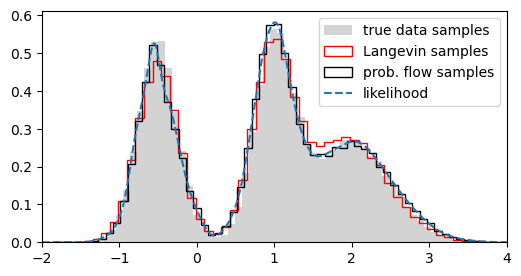

In [170]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
ax = axs
_ = ax.hist(samples0,60,density=True,color='lightgrey',label='true data samples')
_ = ax.hist(sde_samples,60,density=True,histtype='step',color='r',label='Langevin samples')
_ = ax.hist(ode_samples,60,density=True,histtype='step',color='k',label='prob. flow samples')
ax.plot(x,np.exp(logp),'--',label='likelihood')
ax.set_xlim(-2,4)

ax.legend()
plt.savefig('probflow-ll.png')

#### evaluation (Langevin vs. Prob. Flow solutions)

In [171]:
sde_t, sde_samples = sample_sde(score_net = score_net, batch_size = 100000,store_intermediate=True)
sde_samples = sde_samples.squeeze()
ode_t, ode_samples = sample_ode(score_net = score_net, batch_size = 100000,store_intermediate=True)
ode_samples = ode_samples.squeeze()

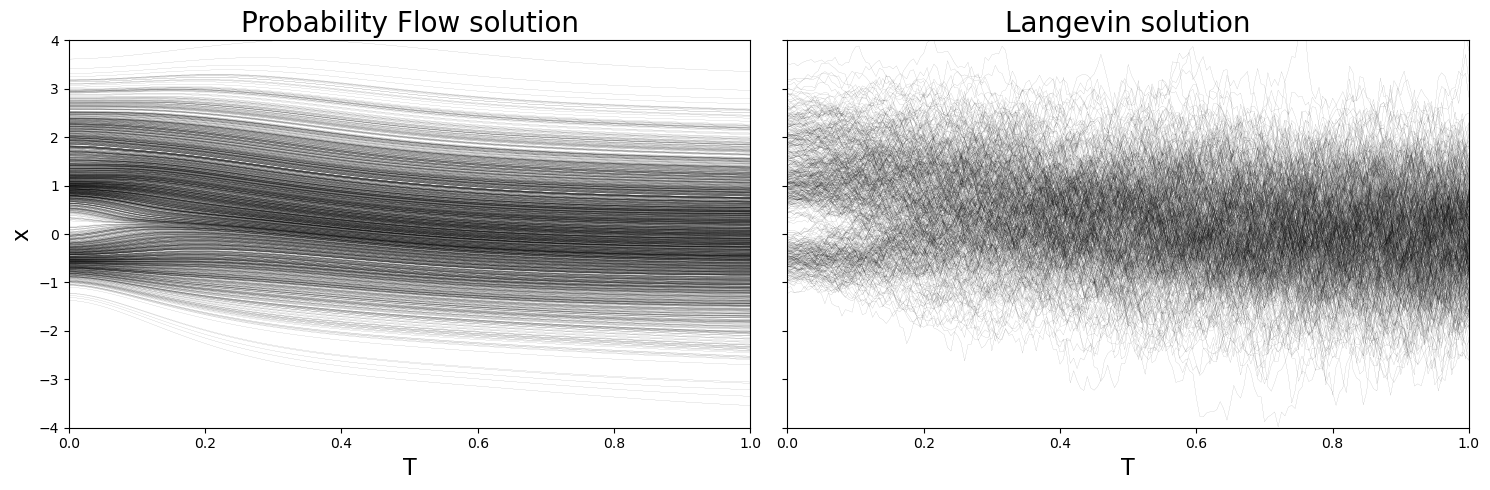

In [172]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5),sharey=True)

ax = axs[0]
for ode_sample in ode_samples[:2000]:
    _ = ax.plot(ode_t, ode_sample,'k',lw=0.05)

ax.set_title('Probability Flow solution',fontsize=20)
ax.set_xlim(0,1)    
ax.set_ylim(-4,4)
ax.set_xlabel('T',fontsize=16)
ax.set_ylabel('x',fontsize=16)

ax = axs[1]
for sde_sample in sde_samples[:500]:
    _ = ax.plot(sde_t, sde_sample,'k',lw=0.05)

ax.set_title('Langevin solution',fontsize=20)
ax.set_xlim(0,1)    
ax.set_ylim(-4,4)
ax.set_xlabel('T',fontsize=16)


plt.tight_layout()
plt.savefig('probflow-solutions.png')